# Playing with Attention Layers

Let's gain an intuition about attention layers and the transformations they perform by playing with different configurations. 

In [1]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2022-10-06 17:19:11.838213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 17:19:11.952495: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-06 17:19:11.975585: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-06 17:19:12.488357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [23]:
## Get some data 
# Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 16, 11
output_size = (240, 360)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size=1

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

print("Getting VideoSet...")
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(VideoSet, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)

Getting VideoSet...


100%|██████████| 16/16 [00:01<00:00, 10.49it/s]


Making patches from Videoset...
Making the flat patch set...
Flattening a tensor of shape:  (None, 3, 15, 22, 2304)
Adding codes to the PatchSet...
Flattening the coded + patched dataset...
Flattening a tensor of shape:  (1, 3, 15, 22, 2495)


Text(0.5, 1.0, 'Random Input: Each Row is a Token')

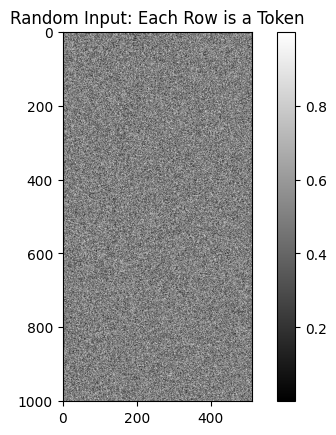

In [45]:
## Generating the data 
M, D = 1001, 512 		# 1001 input tokens, tokens are each 512-dimensional 
input_datum = tf.random.uniform([1, M, D]) # batch size = 1

plt.imshow(input_datum[0,:,:], cmap='gray')
plt.colorbar()
plt.title("Random Input: Each Row is a Token")

In [46]:
## One MHA layer 
n_heads = 1
head_dim = 32
mha_1 = tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=head_dim)
mha_1

In [47]:
## Running the MHA on the input in self-attention style 
mha_output, att_map = mha_1(input_datum, input_datum, return_attention_scores=True)
mha_output.shape # should be [1, M, D]

TensorShape([1, 1001, 512])

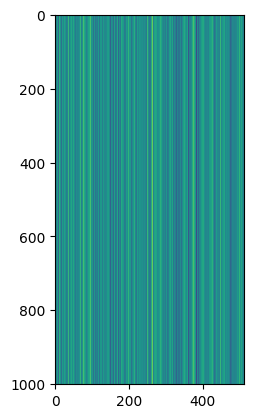

In [48]:
plt.imshow(mha_output[0,:,:])

Reconstruct_me shape:  (1, 240, 360)


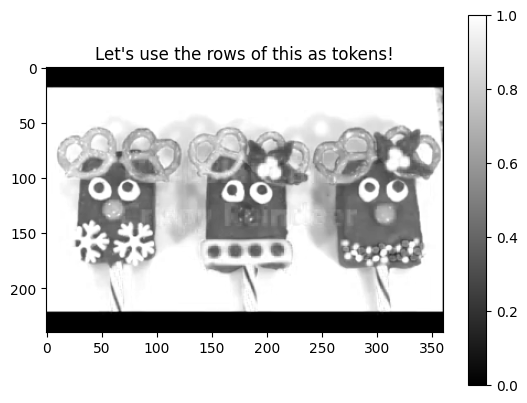

In [91]:
## Let's make a functional Keras model that just has one MHA that tries to reconstruct the input.

video_num = 1

# Getting a candidate frame 
cnt = 0
for element in VideoSet: 
	cnt += 1
	if cnt == video_num:
		candidate_frame = element
		break

reconstruct_me = candidate_frame[:, -1, :,:,0]
plt.imshow(reconstruct_me[0,:,:], cmap='gray')
plt.title("Let's use the rows of this as tokens!")
plt.colorbar()
print("Reconstruct_me shape: ", reconstruct_me.shape)

Text(0.5, 1.0, 'Positionally encoded image')

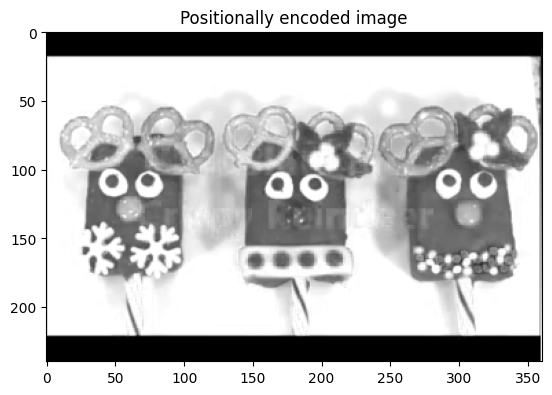

In [100]:
## Now with basic positional encoding
pos_code = tf.range(0, 1, 1/240) 
pos_code = tf.expand_dims(pos_code, axis=0)
pos_code = tf.expand_dims(pos_code, axis=-1)

poscode_reconstruct_me = tf.concat([reconstruct_me, pos_code], axis=2)
poscode_reconstruct_me.shape
plt.imshow(poscode_reconstruct_me[0,:,:], cmap='gray')
plt.title("Positionally encoded image")


In [110]:
## One MHA layer 
n_heads = 32
head_dim = 32
mha_1 = tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=head_dim)

## Running the MHA on the input in self-attention style 
# mha_output, att_map = mha_1(poscode_reconstruct_me, poscode_reconstruct_me, return_attention_scores=True)
# print("Input shape: ", poscode_reconstruct_me.shape)
# print("Output shape: ", mha_output.shape) # should be [1, M, D]
# print("Attention map shape: ", att_map.shape)

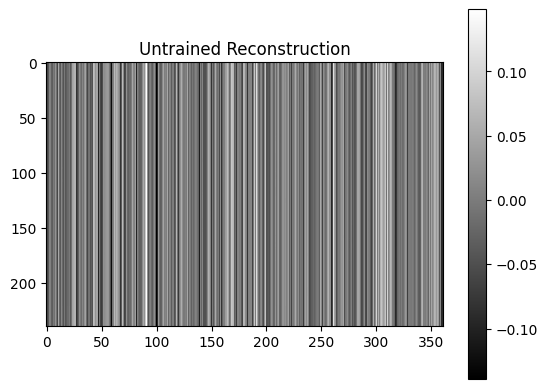

In [106]:
plt.imshow(mha_output[0,:,:], cmap='gray')
plt.title("Untrained Reconstruction")
plt.colorbar()

In [116]:
## Defining the model
batch, M, D = poscode_reconstruct_me.shape

inputs = tf.keras.Input(shape=(M, D))
outputs = mha_1(inputs, inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MHA_Only")
model.summary()

Model: "MHA_Only"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 240, 361)]   0           []                               
                                                                                                  
 multi_head_attention_23 (Multi  (None, 240, 361)    1482089     ['input_13[0][0]',               
 HeadAttention)                                                   'input_13[0][0]']               
                                                                                                  
Total params: 1,482,089
Trainable params: 1,482,089
Non-trainable params: 0
__________________________________________________________________________________________________


In [117]:
## Compiling the model 
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [118]:
history = model.fit(poscode_reconstruct_me, poscode_reconstruct_me, batch_size=1, epochs=320, validation_split=0.0, verbose=0)

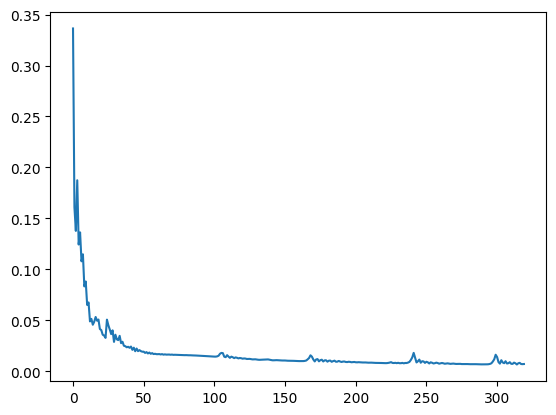

In [119]:
plt.plot(history.history['loss'])

Text(0.5, 1.0, 'Original')

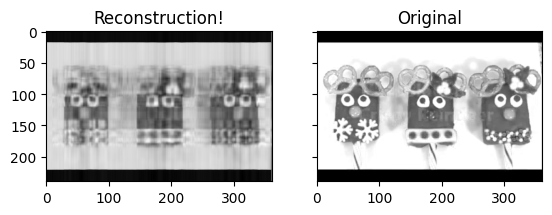

In [121]:
reconstruction = model(poscode_reconstruct_me)

fig, axs = plt.subplots(1,2, sharey=True)

axs[0].imshow(reconstruction[0,:,:], cmap='gray')
axs[0].set_title("Reconstruction!")
axs[1].imshow(poscode_reconstruct_me[0,:,:], cmap='gray')
axs[1].set_title("Original")

## Fuller Model to Autoencode an Image

Let's see if we can make a better model to 